In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import solve_ivp
import numba
# from qs_deterministic import *

# Sistema LasR/LasI con RsaL
[Regulatory functions](https://biocircuits.github.io/chapters/appA_regulatory_functions.html?utm_source=pocket_mylist)

\begin{equation}
    \dot{[lasR]} = \kappa_{lasR} - 
                   [lasR]\gamma_{lasR}
\end{equation}

\begin{equation}
    \dot{[LasR]} = [lasR]\kappa_{LasR} + 
                   [LasR{\cdot}AI_{1}]\sigma_{LasR{\cdot}AI1} - 
                   [AI_{1}][LasR]\mu_{LasR\cdot AI1} -
                   [LasR]\gamma_{LasR}
\end{equation}

\begin{equation}
    \dot{[rsaL]} = \alpha_{rsaL} + 
                   \frac{\beta_{rsaL}}{1+\left(\frac{[LasR{\cdot}AI_1]}{K_1}\right)^{h_1}} -
                   [rsaL]\gamma_{rsaL}
\end{equation}

\begin{equation}
    \dot{[RsaL]} = [rsaL]\kappa_{RsaL} -
                   [RsaL]\gamma_{RsaL}
\end{equation}

\begin{equation}
    \dot{[lasI]} = \alpha_{lasI} + 
                   \beta_{lasI}\frac{\left(\frac{LasR{\cdot}AI_{1}}{K_{1}}\right)^{h_{1}}}{\left(1+\left(\frac{LasR{\cdot}AI_{1}}{K_{1}}\right)^{h_{1}}\right)\left(1+\left(\frac{RsaL}{K_{2}}\right)^{h_{2}}\right)} - 
                   [lasI]\gamma_{lasI}
\end{equation}

\begin{equation}
    \dot{[LasI]} = [lasI]\kappa_{LasI} - 
                   [LasI]\gamma_{LasI}
\end{equation}

\begin{equation}
    \dot{[AI_{1}]} = [LasI]\kappa_{AI1} + 
                     [LasR{\cdot}AI_{1}]\sigma_{LasR{\cdot}AI1} - 
                     [AI_1][LasR]\mu_{LasR{\cdot}AI1} -
                     (d(AI_{1}-AI_{1ext})) -
                     [AI_1]\gamma_{AI1}
\end{equation}

\begin{equation}
    \dot{[AI_{1ext}]} = (N\cdot d(AI_{1}-AI_{1ext})) -
                        [AI_{1ext}](\gamma_{AI1ext}+d_{away})
\end{equation}

\begin{equation}
    \dot{[LasR{\cdot}AI_{1}]} = [AI_{1}][LasR]\mu_{LasR{\cdot}AI1} -
                                [LasR{\cdot}AI_{1}](\sigma_{LasR{\cdot}AI1} + \gamma_{LasR{\cdot}AI1})
\end{equation}

In [2]:
@numba.jit
def LasRI_RsaL_qs(t, r, N=10):
    lasR, LasR, rsaL, RsaL, lasI, LasI, AI1, AI1_ext, LasRAI1 = r
    
    # LasR/LasI
    k_lasR = 0.004
    g_lasR = 0.002
    k_LasR = 0.4
    g_LasR = 0.35
    a_rsaL = 0.00036
    b_rsaL = 0.0058
    K1 = 1.2
    h1 = 1.4   
    g_rsaL = 0.001
    k_RsaL = 0.9
    g_RsaL = 0.2
    a_lasI = 0.00036
    b_lasI = 0.0058
    K2 = 1.4
    h2 = 1.2
    g_lasI = 0.001
    k_LasI = 0.7
    g_LasI = 0.12
    k_AI1 = 1
    g_AI1 = 0.3
    g_AI1_ext = 0.8
    u_LasRAI1 = 0.05
    s_LasRAI1 = 0.25
    g_LasRAI1 = 0.14
    # Cell parameters
    d = 0.8
    d_away = 1.2
    # N = 500

    x = (LasRAI1/K1)**h1  # Activator
    y = (RsaL/K2)**h2     # Repressor
    
    dlasR = k_lasR - lasR*g_lasR
    dLasR = lasR*k_LasR + LasRAI1*s_LasRAI1 - AI1*LasR*u_LasRAI1 - LasR*g_LasR
    drsaL = a_rsaL + b_rsaL*(x/(1+x)) - rsaL*g_rsaL
    dRsaL = rsaL*k_RsaL - RsaL*g_RsaL
    dlasI = a_lasI + (b_lasI*(x/((1+x)*(1+y)))) - lasI*g_lasI
    dLasI = lasI*k_LasI - LasI*g_LasI
    dAI1 = LasI*k_AI1 + LasRAI1*s_LasRAI1 - AI1*LasR*u_LasRAI1 - (d*(AI1-AI1_ext)) - AI1*g_AI1
    dAI1_ext = (N*d*(AI1-AI1_ext)) - (AI1_ext*(g_AI1_ext + d_away))
    dLasRAI1 = AI1*LasR*u_LasRAI1 - (LasRAI1*(s_LasRAI1 + g_LasRAI1))
    
    return np.array([dlasR, dLasR, drsaL, dRsaL, dlasI, dLasI, dAI1, dAI1_ext, dLasRAI1])

In [3]:
LasRI_RsaL_qs_dynamics_short = solve_ivp(LasRI_RsaL_qs, [0, 170], [1, 1, 1, 1, 1, 1, 1, 1, 1])
LasRI_RsaL_qs_dynamics_long = solve_ivp(LasRI_RsaL_qs, [0, 5000], [1, 1, 1, 1, 1, 1, 1, 1, 1])

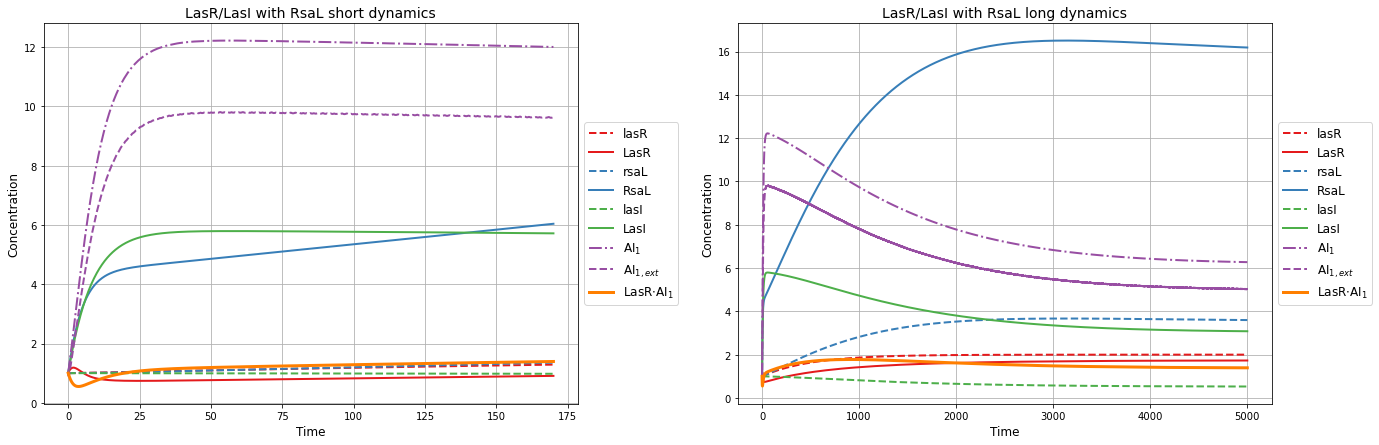

In [4]:
plt.figure(figsize=(22,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[0], lw=2, label='lasR', color=cm.Set1(0), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[1], lw=2, label='LasR', color=cm.Set1(0), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[2], lw=2, label='rsaL', color=cm.Set1(1), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[3], lw=2, label='RsaL', color=cm.Set1(1), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[4], lw=2, label='lasI', color=cm.Set1(2), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[5], lw=2, label='LasI', color=cm.Set1(2), ls='-') 
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[6], lw=2, label='AI$_1$', color=cm.Set1(3), ls='-.')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[7], lw=2, label='AI$_{1,ext}$', color=cm.Set1(3), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[8], lw=3, label='LasR$\cdot$AI$_1$', color=cm.Set1(4), ls='-')
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.20, 0.50), ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.title('LasR/LasI with RsaL short dynamics', fontsize=14)
plt.subplot(1,2,2)
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[0], lw=2, label='lasR', color=cm.Set1(0), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[1], lw=2, label='LasR', color=cm.Set1(0), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[2], lw=2, label='rsaL', color=cm.Set1(1), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[3], lw=2, label='RsaL', color=cm.Set1(1), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[4], lw=2, label='lasI', color=cm.Set1(2), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[5], lw=2, label='LasI', color=cm.Set1(2), ls='-') 
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[6], lw=2, label='AI$_1$', color=cm.Set1(3), ls='-.')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[7], lw=2, label='AI$_{1,ext}$', color=cm.Set1(3), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[8], lw=3, label='LasR$\cdot$AI$_1$', color=cm.Set1(4), ls='-')
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.20, 0.50), ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.title('LasR/LasI with RsaL long dynamics', fontsize=14)
plt.show()

In [5]:
LasRI_RsaL_qs_dynamics_short = solve_ivp(LasRI_RsaL_qs, [0, 170], [1, 1, 1, 1, 1, 1, 1, 1, 1], args=(500,))
LasRI_RsaL_qs_dynamics_long = solve_ivp(LasRI_RsaL_qs, [0, 5000], [1, 1, 1, 1, 1, 1, 1, 1, 1], args=(500,))

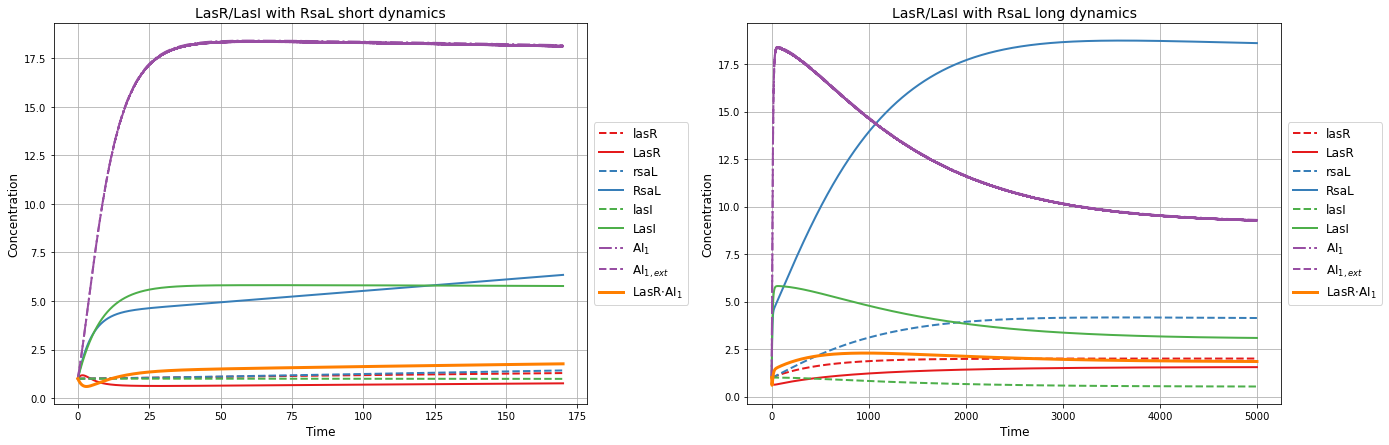

In [6]:
plt.figure(figsize=(22,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[0], lw=2, label='lasR', color=cm.Set1(0), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[1], lw=2, label='LasR', color=cm.Set1(0), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[2], lw=2, label='rsaL', color=cm.Set1(1), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[3], lw=2, label='RsaL', color=cm.Set1(1), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[4], lw=2, label='lasI', color=cm.Set1(2), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[5], lw=2, label='LasI', color=cm.Set1(2), ls='-') 
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[6], lw=2, label='AI$_1$', color=cm.Set1(3), ls='-.')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[7], lw=2, label='AI$_{1,ext}$', color=cm.Set1(3), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_short.t, LasRI_RsaL_qs_dynamics_short.y[8], lw=3, label='LasR$\cdot$AI$_1$', color=cm.Set1(4), ls='-')
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.20, 0.50), ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.title('LasR/LasI with RsaL short dynamics', fontsize=14)
plt.subplot(1,2,2)
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[0], lw=2, label='lasR', color=cm.Set1(0), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[1], lw=2, label='LasR', color=cm.Set1(0), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[2], lw=2, label='rsaL', color=cm.Set1(1), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[3], lw=2, label='RsaL', color=cm.Set1(1), ls='-')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[4], lw=2, label='lasI', color=cm.Set1(2), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[5], lw=2, label='LasI', color=cm.Set1(2), ls='-') 
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[6], lw=2, label='AI$_1$', color=cm.Set1(3), ls='-.')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[7], lw=2, label='AI$_{1,ext}$', color=cm.Set1(3), ls='--')
plt.plot(LasRI_RsaL_qs_dynamics_long.t, LasRI_RsaL_qs_dynamics_long.y[8], lw=3, label='LasR$\cdot$AI$_1$', color=cm.Set1(4), ls='-')
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.20, 0.50), ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.title('LasR/LasI with RsaL long dynamics', fontsize=14)
plt.show()